# Paso 6 - Train unificado (dataset + entrenamiento)

**Flujo**: A partir de `data/interim/` se crea el dataset wide de train, se preprocesa, se cargan features e hiperparámetros en la sección de entrenamiento y se entrena LGBM. El modelo se guarda en **models/lgbm_model.pkl** (sin calibración).

- **Input**: `data/interim/` (parquets), `models/features.pkl`, `models/hyperparams.pkl`.
- **Output**: `data/processed/train/cutoff=<CUTOFF>/train_wide.parquet` y **models/lgbm_model.pkl**.

---
## 1. Imports y path del proyecto

Se agrega la raíz del proyecto a `sys.path` para importar `src` y las funciones de creación de dataset.

In [25]:
import os
import sys
import pandas as pd
import numpy as np
import warnings

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.config import load_config, get_paths
from src.data.make_dataset import create_train_dataset, get_consumo_date_range
from src.preprocessing.preprocessing import preprocess_model_input
from src.modeling.supervised_models import LGBMModel
from src.modeling.helpers import save_model

%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
## 2. Configuración

Se carga desde **config/config.yaml**. Editar allí fechas y parámetros; las notebooks y scripts usan la misma config.

**CUTOFF**: fecha tope de inspecciones. Se consideran todos los meses con inspecciones hasta esa fecha. Para cada mes se arman filas: contratos inspeccionados + 12 meses de consumo anteriores + target; luego se concatenan.

In [26]:
cfg = load_config()
paths = get_paths(cfg)
INTERIM_DIR = paths["interim"]
PROCESSED_DIR = paths["processed"]
MODELS_DIR = paths["models"]

t = cfg["train"]
CUTOFF = t["cutoff"]
CANT_PERIODOS = t["cant_periodos"]
MAX_CTAS_NEG = t["max_ctas_neg"]
SAM_TH = t["sam_th"]
PARAM_IMB_METHOD = t["param_imb_method"]
PREPROCESOR_NUM = t["preprocesor_num"]


---
## 3. Crear dataset de train

Se construye el dataset wide a partir de interim (misma lógica que `2_dataset_creation.ipynb` en modo train). El parquet se guarda en `data/processed/train/cutoff=<CUTOFF>/` y se usa el dataframe en memoria para entrenar.

In [27]:
%%time
df = create_train_dataset(
    INTERIM_DIR, PROCESSED_DIR,
    cant_periodos=CANT_PERIODOS,
    cutoff_max=CUTOFF,
    max_ctas=MAX_CTAS_NEG,
)
if df is None:
    raise RuntimeError("No se pudo crear el dataset de train.")

df.rename(columns={"is_fraud": "target"}, inplace=True)
print(f"Train: {len(df)} filas, target mean = {df['target'].mean():.4f}")

Train dataset: 100%|██████████| 1/1 [00:09<00:00,  9.07s/it]


*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
[OK] Guardado: d:\2024\BID\Aguas\Empresa-EPM\proyecto\ar-epm_poc\data/processed\train\cutoff=2023-02-01\train_wide.parquet (1615 filas)
Train: 1615 filas, target mean = 0.0712
CPU times: total: 28.8 s
Wall time: 1min 24s


---
## 4. Preprocesamiento

Limpieza de variables categóricas y filtrado por `cant_null` y `cant_ceros_12`.

In [28]:
# Preprocesamiento (reusable para train/inference)
df = preprocess_model_input(df)

---
## 5. Entrenamiento LGBM

Se cargan features e hiperparámetros desde **models/**, se instancia `LGBMModel` y se entrena. No se aplica calibración; se usa el modelo entrenado directamente.

In [29]:
import joblib

cols_for_model = joblib.load(os.path.join(MODELS_DIR, "features.pkl"))
HYPERPARAMS = joblib.load(os.path.join(MODELS_DIR, "hyperparams.pkl"))
print(f"Features para modelo: {len(cols_for_model)}")

missing = [c for c in cols_for_model if c not in df.columns]
if missing:
    raise ValueError(f"Columnas faltantes en train_wide: {missing}")
df_train = df.copy()
y_train = df_train["target"]

train_lgbm = LGBMModel(
    cols_for_model,
    hyperparams=HYPERPARAMS,
    search_hip=False,
    sampling_th=SAM_TH,
    preprocesor_num=PREPROCESOR_NUM,
    sampling_method=PARAM_IMB_METHOD,
)
lgbm_model = train_lgbm.train(df_train[cols_for_model], y_train, df_val=None, y_val=None)
print("LGBM entrenado.")

Features para modelo: 42
[LightGBM] [Info] Number of positive: 544, number of negative: 1088
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2662
[LightGBM] [Info] Number of data points in the train set: 1632, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

---
## 6. Guardar modelo en models/

Se guarda el modelo entrenado en `models/lgbm_model.pkl` (sin calibración).

In [30]:
save_model(lgbm_model, os.path.join(MODELS_DIR, "lgbm_model.pkl"))
print(f"[OK] Modelo: {MODELS_DIR}/lgbm_model.pkl")

[OK] Modelo: d:\2024\BID\Aguas\Empresa-EPM\proyecto\ar-epm_poc\models/lgbm_model.pkl


<!-- celda intencionalmente vacia -->

---
## 7. Distribución en el conjunto de datos (opcional)

Distribución del target y del score del modelo en el train.

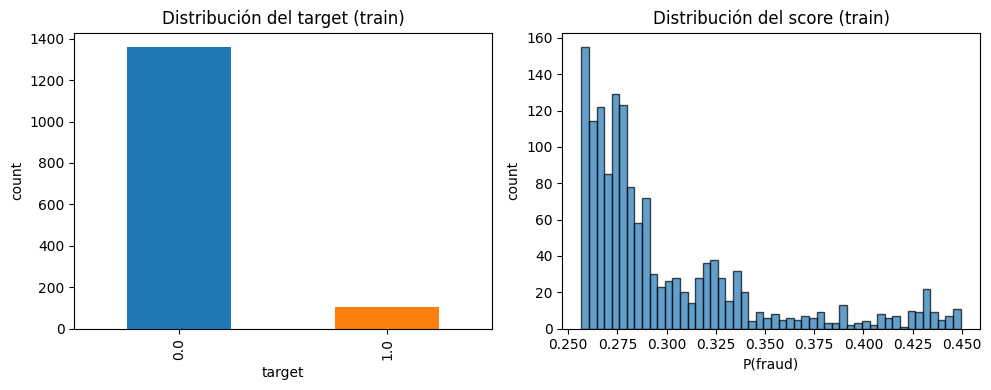

In [31]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

df_train["target"].value_counts().sort_index().plot(kind="bar", ax=axes[0], color=["C0", "C1"])
axes[0].set_title("Distribución del target (train)")
axes[0].set_xlabel("target")
axes[0].set_ylabel("count")

y_score = lgbm_model.predict_proba(df_train[cols_for_model])[:, 1]
axes[1].hist(y_score, bins=50, edgecolor="black", alpha=0.7)
axes[1].set_title("Distribución del score (train)")
axes[1].set_xlabel("P(fraud)")
axes[1].set_ylabel("count")

plt.tight_layout()
plt.show()

In [32]:
# celda intencionalmente vacia